<a href="https://colab.research.google.com/github/teoad95/Deep-learning-Cryptocurrency-price-prediction/blob/main/Classification_using_crypto_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [130]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

In [184]:
eth_market_info = pd.read_csv('BTC-USD.csv')

In [185]:
eth_market_info = eth_market_info.dropna(how='any',axis=0) 
eth_market_info['Date'] = pd.to_datetime(eth_market_info['Date'])
eth_market_info.loc[eth_market_info['Volume']=="-",'Volume']=0
eth_market_info.columns = eth_market_info.columns.str.replace("*", "")

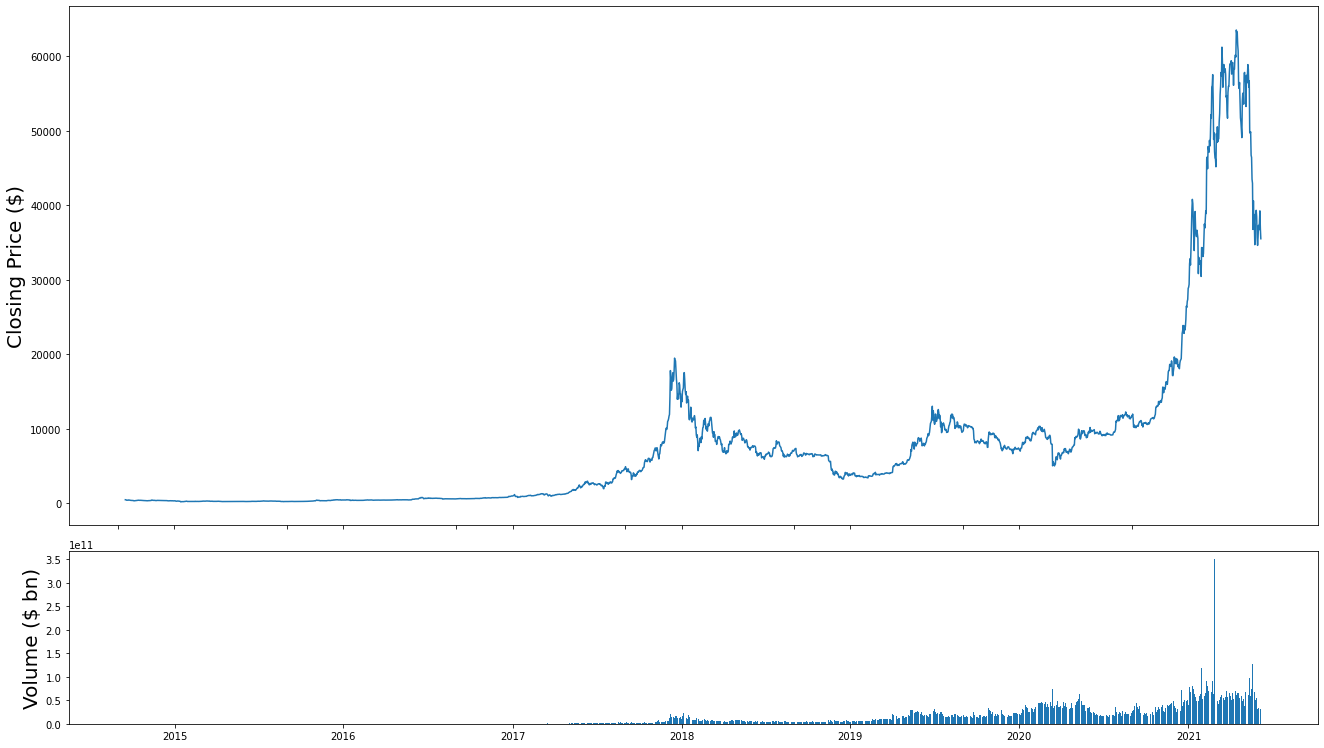

In [186]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
#ax1.set_yscale('log')
ax1.set_ylabel('Closing Price ($)',fontsize=20)
ax2.set_ylabel('Volume ($ bn)',fontsize=20)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2021) for j in [1,9]])
ax1.set_xticklabels('')
ax1.plot(eth_market_info['Date'],eth_market_info['Open'])
ax2.bar(eth_market_info['Date'], eth_market_info['Volume'].values)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
plt.show()

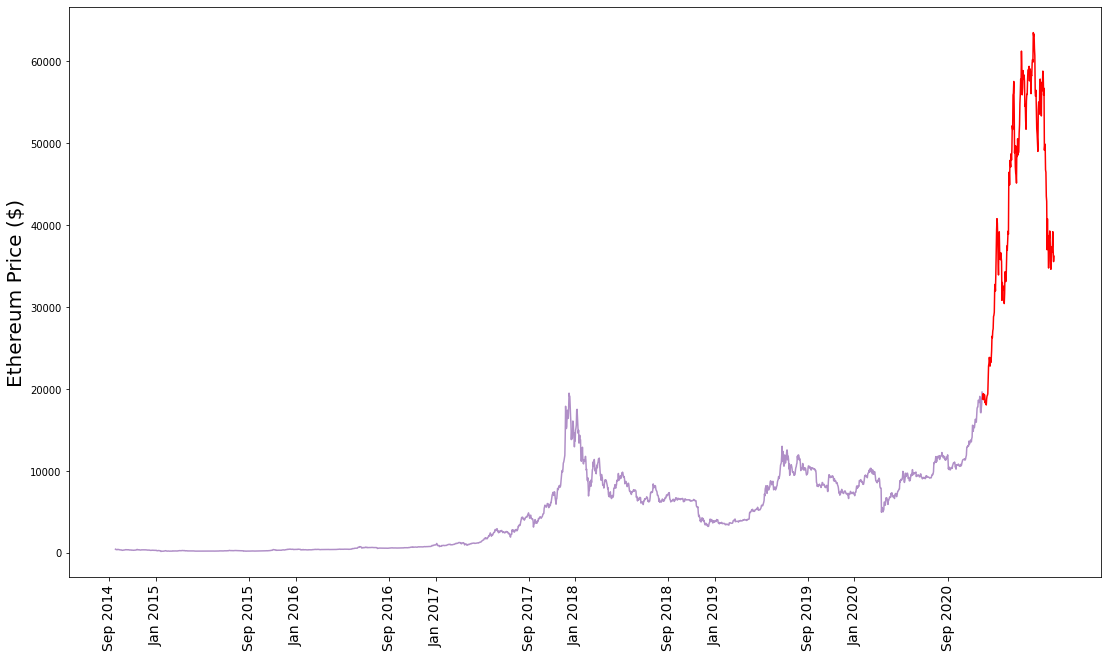

In [188]:
split_date = '2020-12-01'
fig, (ax2) = plt.subplots(1,1)
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2021) for j in [1,9]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2021) for j in [1,9]])
ax2.plot(eth_market_info[eth_market_info['Date'] < split_date]['Date'],
         eth_market_info[eth_market_info['Date'] < split_date]['Close'], 
         color='#B08FC7')
ax2.plot(eth_market_info[eth_market_info['Date'] >= split_date]['Date'],
         eth_market_info[eth_market_info['Date'] >= split_date]['Close'], color='red')
ax2.set_ylabel('Ethereum Price ($)',fontsize=20)
fig.set_size_inches(18.5, 10.5)
plt.xticks(fontsize=14, rotation=90)
plt.show()

In [189]:
window_len = 10

In [190]:
kwargs = {'day_diff': lambda x: (x['Close']-x['Open'])/x['Open'],
          'volatility': lambda x: (x['High']- x['Low'])/(x['Open'])}
eth_market_info = eth_market_info.assign(**kwargs)
eth_market_info['NewColumn'] = eth_market_info['Close'].shift(-1) - eth_market_info['Close'].shift(window_len)
eth_market_info.insert(0, 'Y', eth_market_info['NewColumn'] > 0)
eth_market_info = eth_market_info.drop(['NewColumn'], axis=1)
eth_market_info = eth_market_info.sort_values(by='Date')

In [191]:
model_data = eth_market_info.sort_values(by='Date')
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [192]:
test_set_to_predict_value = test_set['Y'].reset_index(drop=True)
test_set = test_set.drop(['Y'], axis=1)
training_set_to_predict_value = training_set['Y'].reset_index(drop=True)
training_set = training_set.drop(['Y'], axis=1)

In [193]:
from sklearn.preprocessing import MinMaxScaler
# define min max scaler
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
test_set = scaler.transform(test_set)

In [194]:
x_train = []
y_train = []

In [195]:
for i in range(window_len, training_set.shape[0]):
    x_train.append(training_set[i-window_len:i])
    y_train.append(float(training_set_to_predict_value[i]))

In [196]:
x_test = []
y_test = []

In [197]:
for i in range(window_len, test_set.shape[0]):
    x_test.append(test_set[i-window_len:i])
    y_test.append(float(test_set_to_predict_value[i]))

In [198]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.array(x_test), np.array(y_test)

In [199]:
sum_true = 0
sum_false = 0
for i in range(0, len(y_train)):
    if (y_train[i] >= 0.5):
      sum_true += 1
    else:
      sum_false += 1

print(f'In train dataset we have {str(sum_true)} increases and {str(sum_false)} decreases.')

In train dataset we have 1299 increases and 954 decreases.


In [145]:
pip install tensorflow_addons

In [200]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [201]:
def round_predictions(y_pred):
  y_pred_rounded = []
  for i in range(0, len(y_pred)):
    pred = 0
    if (y_pred[i] >= 0.5):
      pred = 1
    y_pred_rounded.append(pred)
  return y_pred_rounded

In [202]:
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix

In [204]:
def ShowMetrics(model, actual, predictions): 
    print('Model used summary:')
    model.summary()
    print('\n\n\n')
    y_pred_new = round_predictions(predictions)
    label_names = ['Decreased', 'Increased']
    cmx = confusion_matrix(actual, y_pred_new)
    df = pd.DataFrame(cmx, columns=label_names, index=label_names)
    df.columns.name = 'prediction'
    df.index.name = 'label'
    print(df)
    print('\n\n\n')
    print('f1 score::' + str(f1_score(actual, y_pred_new)))
    auc = roc_auc_score(actual, predictions)
    print('\n\n\n')
    print('AUC: %.2f' % auc)
    print('\n\n\n')
    fpr, tpr, thresholds = roc_curve(actual, predictions)
    plot_roc_curve(fpr, tpr)

In [205]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow_addons as tfa

def build_model_LSTM_multiple_layers():
    model = Sequential()

    model.add(LSTM(units = 50, activation = 'relu', input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(units=64))
    model.add(Dense(units=1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [ ]:
model_LSTM_multiple_layers = build_model_LSTM_multiple_layers()
history_LSTM_multiple_layers = model.fit(x_train, y_train, epochs = 50, batch_size = 64, validation_split = 0.3, callbacks=[early_stopping])

Epoch 1/50


KeyboardInterrupt: ignored

In [25]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
import tensorflow_addons as tfa
from keras.optimizers import SGD

def build_model_GRU():
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
    #my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    #my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
    my_GRU_model.add(GRU(units=50, activation='tanh'))
    my_GRU_model.add(Dense(units=1))
    my_GRU_model.compile(optimizer='adam',loss='mse')
    return my_GRU_model

In [26]:
model = build_model_GRU()
history = model.fit(x_train, y_train, epochs = 50, batch_size = 64, validation_split = 0.3, callbacks=[early_stopping])

Epoch 1/50
18/18 [==============================] - 5s 69ms/step - loss: 0.3509 - val_loss: 0.2429
Epoch 2/50
18/18 [==============================] - 0s 16ms/step - loss: 0.2393 - val_loss: 0.2495
Epoch 3/50
18/18 [==============================] - 0s 17ms/step - loss: 0.2327 - val_loss: 0.2453
Epoch 4/50
18/18 [==============================] - 0s 17ms/step - loss: 0.2371 - val_loss: 0.2523
Epoch 5/50
18/18 [==============================] - 0s 17ms/step - loss: 0.2358 - val_loss: 0.2473
Epoch 6/50
18/18 [==============================] - 0s 17ms/step - loss: 0.2277 - val_loss: 0.2360
Epoch 7/50
18/18 [==============================] - 0s 16ms/step - loss: 0.2313 - val_loss: 0.2365
Epoch 8/50
18/18 [==============================] - 0s 16ms/step - loss: 0.2317 - val_loss: 0.2405
Epoch 9/50
18/18 [==============================] - 0s 16ms/step - loss: 0.2256 - val_loss: 0.2412
Epoch 10/50
18/18 [==============================] - 0s 18ms/step - loss: 0.2238 - val_loss: 0.2328
Epoch 11/

In [206]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
import tensorflow_addons as tfa
from keras.optimizers import SGD

def build_model_GRU_with_multiple_layers():
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
    my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
    my_GRU_model.add(GRU(units=50, activation='tanh'))
    my_GRU_model.add(Dense(units=1))
    my_GRU_model.compile(optimizer='adam',loss='mse')
    return my_GRU_model

In [207]:
model_GRU_with_multiple_layers = build_model_GRU_with_multiple_layers()
history_GRU_with_multiple_layers = model_GRU_with_multiple_layers.fit(x_train, y_train, epochs = 50, batch_size = 64, validation_split = 0.3, callbacks=[early_stopping])

Epoch 1/50
25/25 [==============================] - 9s 95ms/step - loss: 0.3707 - val_loss: 0.2655
Epoch 2/50
25/25 [==============================] - 1s 31ms/step - loss: 0.2385 - val_loss: 0.2362
Epoch 3/50
25/25 [==============================] - 1s 30ms/step - loss: 0.2397 - val_loss: 0.2338
Epoch 4/50
25/25 [==============================] - 1s 31ms/step - loss: 0.2351 - val_loss: 0.2624
Epoch 5/50
25/25 [==============================] - 1s 30ms/step - loss: 0.2308 - val_loss: 0.3057
Epoch 6/50
25/25 [==============================] - 1s 30ms/step - loss: 0.2361 - val_loss: 0.2808
Epoch 7/50
25/25 [==============================] - 1s 29ms/step - loss: 0.2289 - val_loss: 0.2786
Epoch 8/50
25/25 [==============================] - 1s 31ms/step - loss: 0.2136 - val_loss: 0.3842
Epoch 9/50
25/25 [==============================] - 1s 32ms/step - loss: 0.2070 - val_loss: 0.4652
Epoch 10/50
25/25 [==============================] - 1s 31ms/step - loss: 0.2014 - val_loss: 0.5478
Epoch 11/

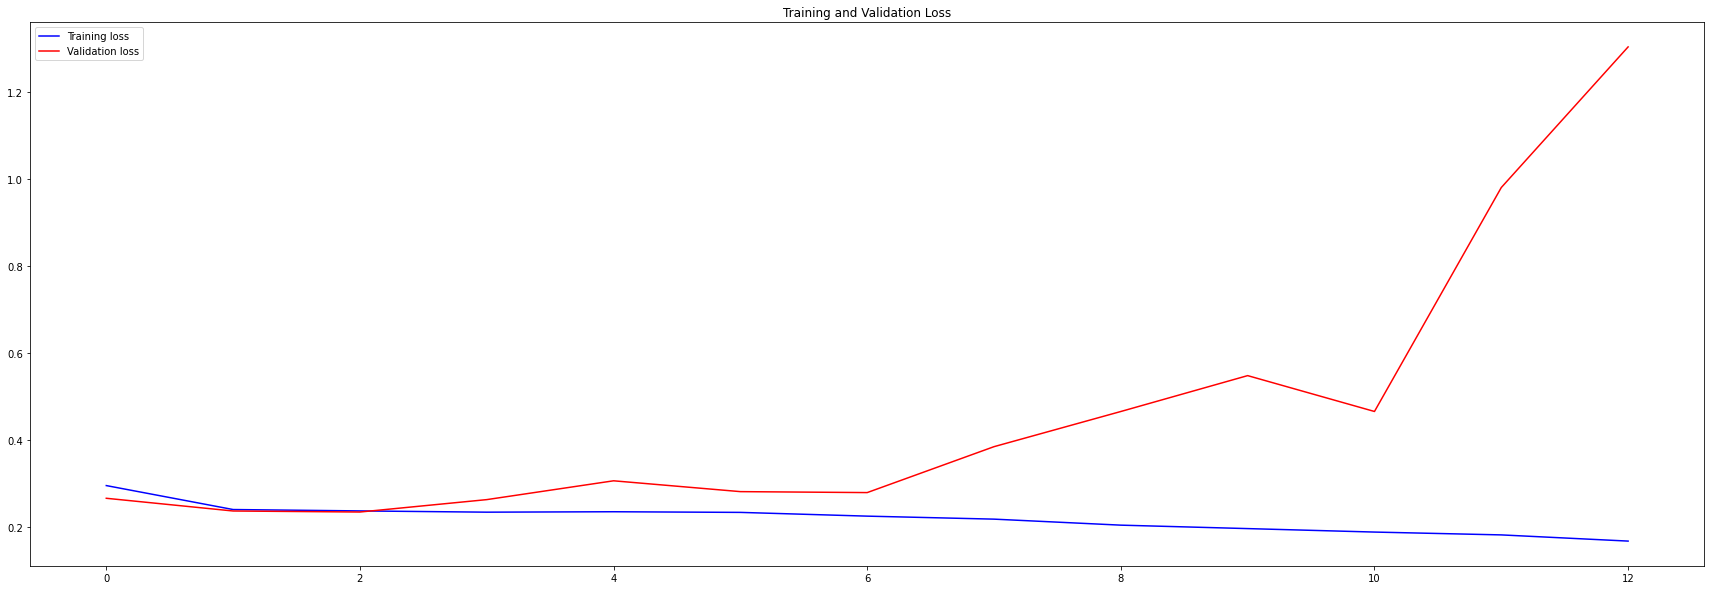

In [208]:
loss = history_GRU_with_multiple_layers.history['loss']
val_loss = history_GRU_with_multiple_layers.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(30,10))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Model used summary:
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_29 (GRU)                 (None, 10, 50)            9000      
_________________________________________________________________
gru_30 (GRU)                 (None, 10, 50)            15300     
_________________________________________________________________
gru_31 (GRU)                 (None, 10, 50)            15300     
_________________________________________________________________
gru_32 (GRU)                 (None, 50)                15300     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 51        
Total params: 54,951
Trainable params: 54,951
Non-trainable params: 0
_________________________________________________________________




prediction  Decreased  Increased
label                           
Decreased          71    

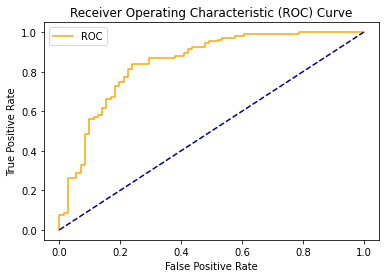

In [209]:
ShowMetrics(model_GRU_with_multiple_layers, y_test, model_GRU_with_multiple_layers.predict(x_test))

In [180]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout
import tensorflow_addons as tfa
from keras.optimizers import SGD

def build_model_GRU_with_single_layer():
    my_GRU_model = Sequential()
    # First GRU layer with Dropout regularisation
    my_GRU_model.add(GRU(units=50, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
    #my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
    #my_GRU_model.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
    #my_GRU_model.add(GRU(units=50, activation='tanh'))
    #my_GRU_model.add(Dropout(0.2))
    my_GRU_model.add(Dense(units=1))
    my_GRU_model.compile(optimizer='adam',loss='mse')
    return my_GRU_model

In [181]:
model_GRU_with_single_layer = build_model_GRU_with_single_layer()
history_GRU_with_single_layer = model_GRU_with_single_layer.fit(x_train, y_train, epochs = 50, batch_size = 64, validation_split = 0.3, callbacks=[early_stopping])

Epoch 1/50
18/18 [==============================] - 3s 86ms/step - loss: 0.3372 - val_loss: 0.2615
Epoch 2/50
18/18 [==============================] - 0s 10ms/step - loss: 0.2346 - val_loss: 0.2590
Epoch 3/50
18/18 [==============================] - 0s 10ms/step - loss: 0.2350 - val_loss: 0.2702
Epoch 4/50
18/18 [==============================] - 0s 11ms/step - loss: 0.2344 - val_loss: 0.2657
Epoch 5/50
18/18 [==============================] - 0s 10ms/step - loss: 0.2249 - val_loss: 0.2630
Epoch 6/50
18/18 [==============================] - 0s 9ms/step - loss: 0.2287 - val_loss: 0.2483
Epoch 7/50
18/18 [==============================] - 0s 10ms/step - loss: 0.2260 - val_loss: 0.2547
Epoch 8/50
18/18 [==============================] - 0s 9ms/step - loss: 0.2252 - val_loss: 0.2829
Epoch 9/50
18/18 [==============================] - 0s 10ms/step - loss: 0.2241 - val_loss: 0.2602
Epoch 10/50
18/18 [==============================] - 0s 9ms/step - loss: 0.2165 - val_loss: 0.2678
Epoch 11/50


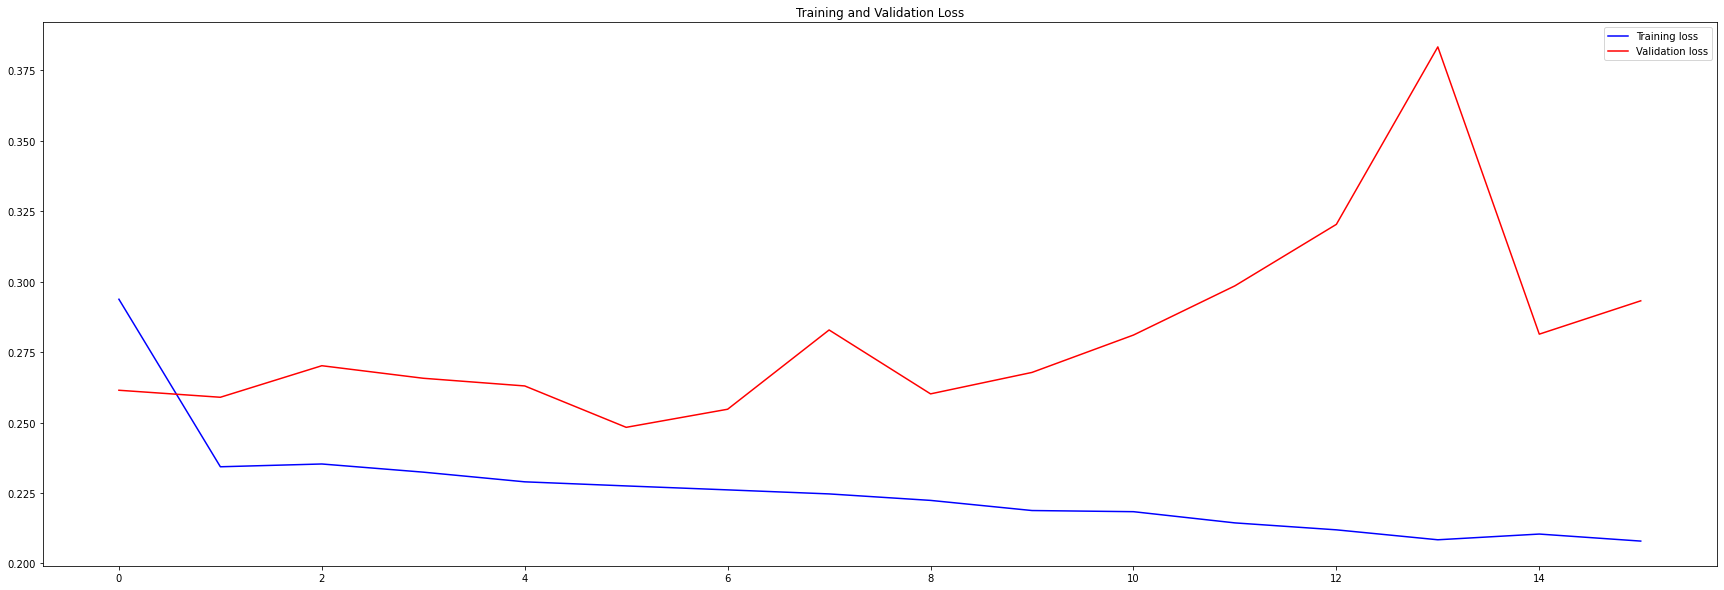

In [182]:
loss = history_GRU_with_single_layer.history['loss']
val_loss = history_GRU_with_single_layer.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(30,10))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

Model used summary:
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_23 (GRU)                 (None, 50)                9000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 51        
Total params: 9,051
Trainable params: 9,051
Non-trainable params: 0
_________________________________________________________________




prediction  Decreased  Increased
label                           
Decreased           8        144
Increased           7        360




f1 score::0.8266360505166476




AUC: 0.64






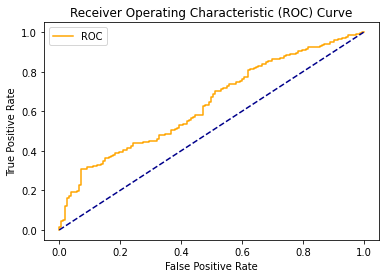

In [175]:
ShowMetrics(model_GRU_with_single_layer, y_test, model_GRU_with_single_layer.predict(x_test))

Model used summary:
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_28 (GRU)                 (None, 50)                9000      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 51        
Total params: 9,051
Trainable params: 9,051
Non-trainable params: 0
_________________________________________________________________




prediction  Decreased  Increased
label                           
Decreased           0        152
Increased           0        367




f1 score::0.8284424379232506




AUC: 0.64






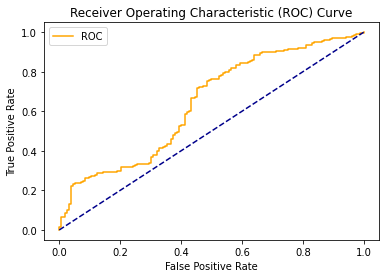

In [183]:
ShowMetrics(model_GRU_with_single_layer, y_test, model_GRU_with_single_layer.predict(x_test))